In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
dry_bean = fetch_ucirepo(id=602) 
  
# data (as pandas dataframes) 
X = dry_bean.data.features 
y = dry_bean.data.targets 
  
# metadata 
print(dry_bean.metadata) 
  
# variable information 
print(dry_bean.variables) 


{'uci_id': 602, 'name': 'Dry Bean', 'repository_url': 'https://archive.ics.uci.edu/dataset/602/dry+bean+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/602/data.csv', 'abstract': 'Images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera. A total of 16 features; 12 dimensions and 4 shape forms, were obtained from the grains.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 13611, 'num_features': 16, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Thu Mar 28 2024', 'dataset_doi': '10.24432/C50S4B', 'creators': [], 'intro_paper': {'ID': 244, 'type': 'NATIVE', 'title': 'Multiclass classification of dry beans using computer vision and machine learning techniques', 'authors': 'M. Koklu, Ilker Ali Özkan', 'venue': 'Co

In [2]:
# Une la columna de la variable objetivo al conjunto de datos (CLASES)
X=X.join(y)

# Modifica el nombre de las columnas a números enteros
X.columns = range(17)

#Se imprime el conjunto de datos
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653247,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


In [3]:
# DATOS CONOCIDOS: 50% registros aleatorios
d_conocidos = X.sample(frac=0.5, random_state=0)

# DATOS DESCONOCIDOS: 50% restante
d_desconocidos = X.drop(d_conocidos.index)

In [4]:
#Demostración del 50% de datos conocidos y desconocidos
print(f"{d_conocidos.shape[0]} registros conocidos y {d_desconocidos.shape[0]} registros desconocidos")

6806 registros conocidos y 6805 registros desconocidos


In [5]:
atributos = [0, 2, 4, 6, 10, 16] #ID = 426440 INDEX 16 es la clase
d_conocidos = d_conocidos[atributos]
d_desconocidos = d_desconocidos[atributos]

In [6]:
from scipy.spatial import distance
from tqdm.notebook import tqdm
import concurrent.futures
import numpy as np
import multiprocessing
import pandas as pd

# Convierte los datos a arreglos de numpy (las primeras cinco columnas)
d_desconocidos_array = d_desconocidos.iloc[:, :5].values
d_conocidos_array = d_conocidos.iloc[:, :5].values

# Clases de los datos conocidos
d_conocidos_classes = d_conocidos[16].values


# Computa la similitud entre un registro desconocido y todos los registros conocidos
def compute_similitudes(i):

    # Calcula la distancia euclidiana entre el registro desconocido y todos los registros conocidos
    distances = np.linalg.norm(d_conocidos_array - d_desconocidos_array[i], axis=1)
    return {
        'index': np.arange(d_conocidos_array.shape[0]),
        'similitud': distances,
        'class': d_conocidos_classes
    }

# Ejecuta la computación de similitudes en paralelo
def run_similarity_computation():
    registros_similitudes = []

    # Utiliza un ThreadPoolExecutor para ejecutar la computación en paralelo
    with concurrent.futures.ThreadPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:

        # Ejecuta la computación en paralelo para cada registro desconocido
        futures = {executor.submit(compute_similitudes, i): i for i in range(d_desconocidos_array.shape[0])}
        
        # Recopila los resultados de la computación en paralelo a medida que se completan
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            try:
                registros_similitudes.append(future.result())
            except Exception as e:
                print(f"Error processing future: {e}")
        
        similitudes_df = pd.DataFrame(registros_similitudes)
    return similitudes_df

registros_similitudes = run_similarity_computation()


  0%|          | 0/6805 [00:00<?, ?it/s]

In [7]:
registros_similitudes

,index,similitud,class
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[3153.7896472807383, 8623.386310784124, 4519.5...","[DERMASON, DERMASON, DERMASON, SIRA, SEKER, CA..."
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[6070.097586853784, 5706.136851607374, 7436.87...","[DERMASON, DERMASON, DERMASON, SIRA, SEKER, CA..."
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[5133.9362211032, 6642.09168683986, 6500.63353...","[DERMASON, DERMASON, DERMASON, SIRA, SEKER, CA..."
3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[3098.4256345708927, 8676.446632144976, 4465.5...","[DERMASON, DERMASON, DERMASON, SIRA, SEKER, CA..."
4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[3750.6633059165692, 8024.70760164783, 5117.52...","[DERMASON, DERMASON, DERMASON, SIRA, SEKER, CA..."
...,...,...,...
6800,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[6834.458297669816, 18608.3353587038, 5468.011...","[DERMASON, DERMASON, DERMASON, SIRA, SEKER, CA..."
6801,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[6740.203143900562, 18514.262882413754, 5372.9...","[DERMASON, DERMASON, DERMASON, SIRA, SEKER, CA..."
6802,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[6812.294605226496, 18586.363204387828, 5445.0...","[DERMASON, DERMASON, DERMASON, SIRA, SEKER, CA..."
6803,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[6781.990034514557, 18555.9748952334, 5415.244...","[DERMASON, DERMASON, DERMASON, SIRA, SEKER, CA..."


In [8]:
# Ordena las similitudes de cada registro desconocido
def sort_row(row):
    sorted_indices = np.argsort(row['similitud'])
    row['index'] = np.array(row['index'])[sorted_indices].tolist()
    row['similitud'] = np.array(row['similitud'])[sorted_indices].tolist()
    row['class'] = np.array(row['class'])[sorted_indices].tolist()
    return row

# Aplica la función de ordenamiento a cada fila
registros_similitudes = registros_similitudes.apply(sort_row, axis=1)

In [9]:
# K's predefinidas
K = [3, 5, 7, 11, 13]

# Función para predecir las clases de los registros desconocidos
def predict_classes(k):
    predictions = []
    for i, row in registros_similitudes.iterrows():
        top_k_classes = row['class'][:k]
        predicted_class = max(set(top_k_classes), key=top_k_classes.count)
        predictions.append(predicted_class)
    return predictions

for k in K:
    registros_similitudes[f'predicted_class_k_{k}'] = predict_classes(k)

registros_similitudes

,index,similitud,class,predicted_class_k_3,predicted_class_k_5,predicted_class_k_7,predicted_class_k_11,predicted_class_k_13
0,"[2231, 208, 901, 1306, 2966, 5683, 2596, 2683,...","[35.94609211890536, 81.45760307021575, 84.6275...","[DERMASON, SEKER, SEKER, SEKER, DERMASON, SEKE...",SEKER,SEKER,SEKER,SEKER,SEKER
1,"[2920, 2259, 3857, 5216, 5215, 4141, 1841, 351...","[45.42785173011869, 54.64833939981323, 57.9452...","[SEKER, SEKER, DERMASON, DERMASON, DERMASON, D...",SEKER,DERMASON,DERMASON,DERMASON,DERMASON
2,"[4861, 1795, 4464, 2486, 4744, 2924, 2824, 135...","[21.78786969865643, 31.40614723601934, 34.8268...","[SEKER, DERMASON, DERMASON, DERMASON, DERMASON...",DERMASON,DERMASON,DERMASON,DERMASON,DERMASON
3,"[1306, 901, 677, 6123, 208, 1990, 2596, 3065, ...","[12.111373258469216, 32.39629920466816, 32.397...","[SEKER, SEKER, DERMASON, SEKER, SEKER, SEKER, ...",SEKER,SEKER,SEKER,SEKER,SEKER
4,"[4175, 2266, 2503, 1114, 2508, 1589, 4153, 347...","[34.60615321948887, 50.95763332004486, 52.9568...","[SEKER, SEKER, SEKER, SEKER, SEKER, DERMASON, ...",SEKER,SEKER,SEKER,SEKER,DERMASON
...,...,...,...,...,...,...,...,...
6800,"[6377, 2763, 4823, 5981, 3107, 3569, 5015, 514...","[32.980801143495256, 33.94581490132783, 35.246...","[SEKER, SIRA, SIRA, SIRA, SIRA, SIRA, DERMASON...",SIRA,SIRA,SIRA,SIRA,SIRA
6801,"[6077, 920, 1483, 3414, 4288, 6550, 1876, 651,...","[15.360450471087523, 30.62969253146595, 30.804...","[SIRA, DERMASON, DERMASON, SIRA, SIRA, SEKER, ...",DERMASON,SIRA,SIRA,SIRA,SIRA
6802,"[5015, 1860, 5148, 5317, 5931, 4288, 3414, 920...","[16.219124940986635, 18.948662471551646, 20.76...","[DERMASON, SIRA, SIRA, SIRA, SEKER, SIRA, SIRA...",SIRA,SIRA,SIRA,SIRA,SIRA
6803,"[3569, 3107, 1483, 4823, 3414, 5981, 4288, 501...","[13.918919315965478, 22.52461294955482, 27.970...","[SIRA, SIRA, DERMASON, SIRA, SIRA, SIRA, SIRA,...",SIRA,SIRA,SIRA,SIRA,SIRA


In [10]:
# Calcula la precisión de las predicciones para cada valor de k
accuracy_results = {}

for k in K:
    correct_predictions = registros_similitudes[f'predicted_class_k_{k}'] == d_desconocidos[16].values
    accuracy = correct_predictions.mean() * 100
    accuracy_results[f'accuracy_k_{k}'] = accuracy

accuracy_results

{'accuracy_k_3': 67.99412196914034,
 'accuracy_k_5': 67.61204996326231,
 'accuracy_k_7': 66.95077149155033,
 'accuracy_k_11': 66.74504041146217,
 'accuracy_k_13': 66.31888317413667}

In [38]:
a=confusion_matrix(3)
print(sum(sum(a.to_numpy())))

3467


In [31]:
def confusion_matrix(k):
    confusion_matrix = pd.crosstab(d_desconocidos[16], registros_similitudes[f'predicted_class_k_{k}'], rownames=['Actual'], colnames=['Predicted'])
    
    return confusion_matrix


with open('confusion_matrix_k.txt', 'w') as f:
    for k in K:
        f.write(f"Confusion matrix for k={k}\n")
        f.write(confusion_matrix(k).to_string())
        f.write("\n\n")

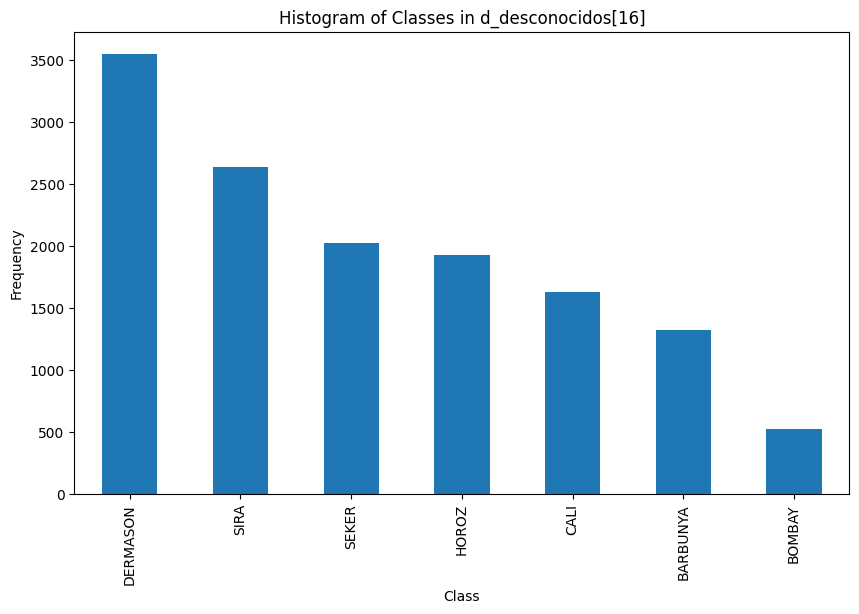

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
X[16].value_counts().plot(kind='bar')
plt.title('Histogram of Classes in d_desconocidos[16]')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()